# Load the pre-trained aesthetic classifier

In [3]:
!pip install -qq transformers diffusers

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from diffusers import StableDiffusionPipeline, LMSDiscreteScheduler
from tqdm.auto import tqdm
from PIL import Image

In [5]:
# Load the SD pipeline and add a hook
device = 'cuda'
pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base").to(device)
pipe.scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
pipe.scheduler.set_timesteps(30)

# lora_model_path = "fantasyfish/zhang_xiaogang-lora"
# pipe.unet.load_attn_procs(lora_model_path)

def hook_fn(module, input, output):
    module.output = output
pipe.unet.mid_block.register_forward_hook(hook_fn);

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [6]:
# Download the model weights
from huggingface_hub import hf_hub_download
model_path = hf_hub_download(repo_id="johnowhitaker/sac_midu_mini", filename="m_small_1e.pt")

In [7]:
import torch
import torch.nn as nn

device = "cuda"
model = nn.Sequential(
    nn.Conv2d(1280, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(256, 128, kernel_size=3, padding=1                                                                                                                ), nn.ReLU(),
    nn.AdaptiveAvgPool2d(output_size=(2, 2)), nn.Flatten(),
    nn.Linear(128*4, 64), nn.ReLU(), nn.Linear(64, 10)
).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

Sequential(
  (0): Conv2d(1280, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): AdaptiveAvgPool2d(output_size=(2, 2))
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=512, out_features=64, bias=True)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=10, bias=True)
)

In [8]:
# Define our aesthetic loss (lower = better)
def aesthetic_loss(x):
    x = model(x.to(device)) # model outputs
    x = F.softmax(x) # to probs (10 classes)
    x = x * torch.arange(10)[None, :].to(device) # to a score, many ways to do this!
    return -x.mean()

In [9]:
def sample(prompt, guidance_loss_scale, guidance_scale=10,
         negative_prompt = "zoomed in, blurry, oversaturated, warped",
         num_inference_steps=30, start_latents = None,
         early_stop = 20, cfg_norm=True, cfg_decay=True ):

    # If no starting point is passed, create one
    if start_latents is None:
      start_latents = torch.randn((1, 4, 64, 64), device=device)

    pipe.scheduler.set_timesteps(num_inference_steps)

    # Encode the prompt
    text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

    # Create our random starting point
    latents = start_latents.clone()
    latents *= pipe.scheduler.init_noise_sigma

    # Prepare the scheduler
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Loop through the sampling timesteps
    for i, t in tqdm(enumerate(pipe.scheduler.timesteps)):

        if i > early_stop: guidance_loss_scale = 0 # Early stop (optional)

        sigma = pipe.scheduler.sigmas[i]

        # Set requires grad
        if guidance_loss_scale != 0: latents = latents.detach().requires_grad_()

        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2)

        # Apply any scaling required by the scheduler
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual with the unet
        if guidance_loss_scale != 0:
            noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        else:
            with torch.no_grad():
                noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform CFG
        cfg_scale = guidance_scale
        if cfg_decay: cfg_scale = 1 + guidance_scale * (1-i/num_inference_steps)
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + cfg_scale * (noise_pred_text - noise_pred_uncond)
        # Normalize (see https://enzokro.dev/blog/posts/2022-11-15-guidance-expts-1/)
        if cfg_norm:
          noise_pred = noise_pred * (torch.linalg.norm(noise_pred_uncond) / torch.linalg.norm(noise_pred))

        if guidance_loss_scale != 0:
            # Calculate our aesthetic loss
            loss = aesthetic_loss(pipe.unet.mid_block.output)

            # Get gradient
            cond_grad = torch.autograd.grad(loss*guidance_loss_scale, latents)[0]

            # Modify the latents based on this gradient
            latents = latents.detach() - cond_grad  * sigma**2

        # compute the previous noisy sample x_t -> x_t-1
        latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

    # Decode the resulting latents into an image
    with torch.no_grad():
        image = pipe.decode_latents(latents.detach())

    return pipe.numpy_to_pil(image)[0]


# Inference
`guidance_loss_scale` is how much you want the aesthetic guidance to be involved in the image generation, `sl` is the starting seed for the generation process. Feel free to play with these two if you're unsatisfied with the result

In [10]:
# Create some starting latents to allow direct comparison
sl = torch.randn((1, 4, 64, 64), device=device)

0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:471: FutureWarning: The decode_latents method is deprecated and will be removed in a future version. Please use VaeImageProcessor instead
  warnings.warn(


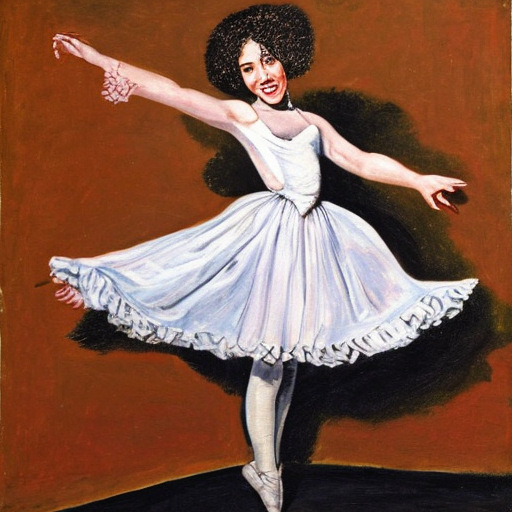

In [11]:
# Sample with guidance_loss_scale=0 (no guidance):
sample("a painting of a girl dancing on top of a table.", guidance_loss_scale=0, start_latents=sl)

0it [00:00, ?it/s]

<ipython-input-8-41c19fda51b4>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x) # to probs (10 classes)


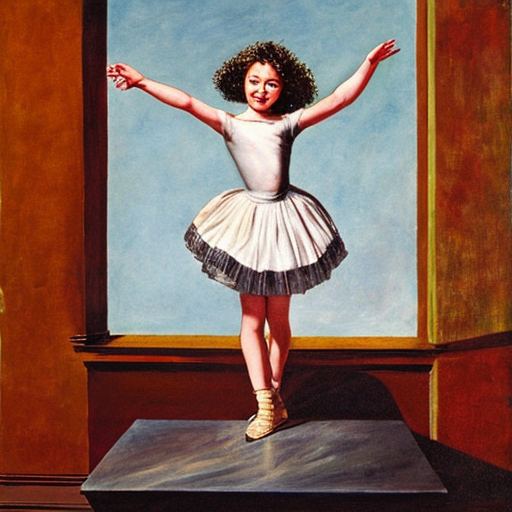

In [12]:
# Sample with guidance_loss_scale=30, using the same starting latents:
sample("a painting of a girl dancing on top of a table.", guidance_loss_scale=30, start_latents=sl)

0it [00:00, ?it/s]

<ipython-input-8-41c19fda51b4>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x) # to probs (10 classes)


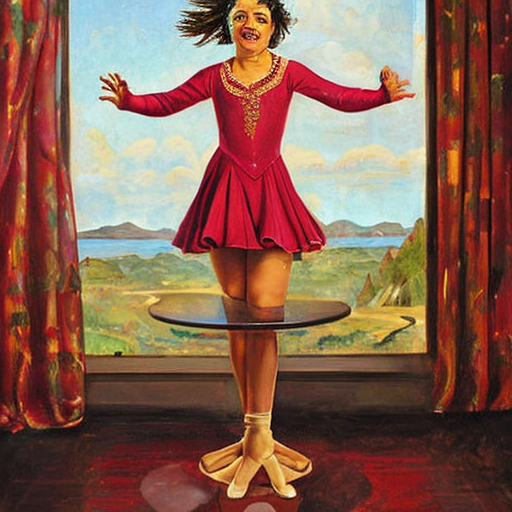

In [13]:
# Another sample, more steps, new starting point (not passing start_latents)
sample("a painting of a girl dancing on top of a table.", guidance_loss_scale=30,
       num_inference_steps=50, early_stop=40)